In [1]:
pip install yfinance

In [2]:
import yfinance as yf

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = yf.download('ESCORTS.NS',period='5y',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-17,645.000000,649.599976,615.250000,617.950012,607.538269,2445573
2018-10-19,611.099976,616.000000,583.500000,604.349976,594.167297,1719936
2018-10-22,607.000000,613.799988,570.450012,573.349976,563.689697,1593082


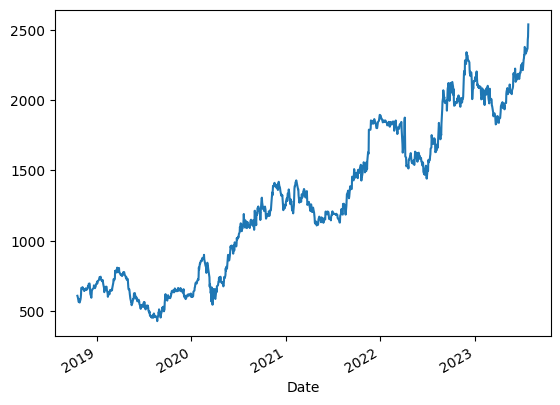

In [5]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
data = data.loc[:,["Adj Close"]].values

plot = data_target.plot()

In [6]:
#Check Length
print("Length of Data:{}".format(len(data)))
print("Length of Data_Target:{}".format(len(data_target)))

Length of Data:1236
Length of Data_Target:1182


In [7]:
#Scaling Dataset
def scaledata(data_target):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    return data_target_scaled, scaler

In [8]:
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
data_target_scaled

(1182,)
(1182,)


array([[0.08541862],
       [0.07908017],
       [0.0646324 ],
       ...,
       [0.94951417],
       [0.95852103],
       [1.        ]])

In [9]:
data_test_scaled = scaledata(data_test)[0]

(104,)


In [10]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)

    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)

    return x_patern,y_price

In [12]:
train_pattern = createPatternSet(data_target_scaled,steps=50)

x_train = train_pattern[0]
x_train.shape

y_train = train_pattern[1]
y_train.shape

(1132,)

In [13]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch

    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))

        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))

        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))

        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()

    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history

    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")

In [14]:
RNN1 = StocksPriceRNN(x_train,y_train,50)

In [15]:
RNN1.buildArchitecture(2,0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [16]:
RNN1.compiler()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [17]:
history = RNN1.modelfit()

Epoch 1/50
29/29 [==============================] - 4s 42ms/step - loss: 0.3788 - val_loss: 0.0033
Epoch 2/50
29/29 [==============================] - 1s 28ms/step - loss: 0.1971 - val_loss: 0.0440
Epoch 3/50
29/29 [==============================] - 1s 29ms/step - loss: 0.1645 - val_loss: 0.0031
Epoch 4/50
29/29 [==============================] - 1s 41ms/step - loss: 0.1121 - val_loss: 0.0093
Epoch 5/50
29/29 [==============================] - 1s 43ms/step - loss: 0.0932 - val_loss: 0.0023
Epoch 6/50
29/29 [==============================] - 1s 27ms/step - loss: 0.0653 - val_loss: 0.0073
Epoch 7/50
29/29 [==============================] - 1s 29ms/step - loss: 0.0691 - val_loss: 0.0017
Epoch 8/50
29/29 [==============================] - 1s 29ms/step - loss: 0.0521 - val_loss: 0.0018
Epoch 9/50
29/29 [==============================] - 1s 29ms/step - loss: 0.0454 - val_loss: 0.0024
Epoch 10/50
29/29 [==============================] - 1s 29ms/step - loss: 0.0372 - val_loss: 0.0017
Epoch 11/

In [18]:
#Prepare Test Data
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)

test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]


In [19]:
#Predict the value for test set
y_test

array([0.76997051, 0.77568822, 0.77119914, 0.76642646, 0.76498523,
       0.77779099, 0.78589513, 0.79201444, 0.82580082, 0.83536968,
       0.82915582, 0.83494436, 0.83572418, 0.85110519, 0.82268202,
       0.80661575, 0.81731881, 0.83078616, 0.82981736, 0.81445995,
       0.82726566, 0.8336449 , 0.81942157, 0.82570638, 0.8190672 ,
       0.81616101, 0.83725985, 0.83716541, 0.83716541, 0.86326151,
       0.86008543, 0.84574556, 0.86968485, 0.86072544, 0.8464329 ,
       0.88101461, 0.88530462, 0.89608916, 0.89585213, 0.92410529,
       0.91829823, 0.90929137, 0.90189621, 0.90891211, 0.90843806,
       0.91557247, 0.9190093 , 0.94951417, 0.95852103, 1.        ,
       1.00123245, 1.01265699, 1.02915379, 1.00599663, 1.01834553,
       1.00609141, 1.02635685, 1.02450812, 1.02225641, 1.01962543,
       1.02564579, 1.07871514, 1.12019412, 1.14896876, 1.14749918,
       1.18829081, 1.17241029, 1.21396032, 1.24396742, 1.23486577,
       1.24107569, 1.33936905, 1.29504581, 1.28302871, 1.23692

In [20]:
x_test

array([[[0.74875363],
        [0.74516235],
        [0.74913167],
        ...,
        [0.77481397],
        [0.7974486 ],
        [0.78220924]],

       [[0.74516235],
        [0.74913167],
        [0.74686346],
        ...,
        [0.7974486 ],
        [0.78220924],
        [0.76997051]],

       [[0.74913167],
        [0.74686346],
        [0.72623717],
        ...,
        [0.78220924],
        [0.76997051],
        [0.77568822]],

       ...,

       [[1.01265699],
        [1.02915379],
        [1.00599663],
        ...,
        [1.40606721],
        [1.40914851],
        [1.41569036]],

       [[1.02915379],
        [1.00599663],
        [1.01834553],
        ...,
        [1.40914851],
        [1.41569036],
        [1.3991225 ]],

       [[1.00599663],
        [1.01834553],
        [1.00609141],
        ...,
        [1.41569036],
        [1.3991225 ],
        [1.39288873]]])

In [21]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 0s 7ms/step


(104, 1)

In [22]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

output

array([[2081.5422],
       [2086.3542],
       [2085.7627],
       [2079.366 ],
       [2076.404 ],
       [2072.1074],
       [2068.2166],
       [2069.7114],
       [2070.0776],
       [2088.6465],
       [2110.6035],
       [2128.1252],
       [2141.5432],
       [2151.351 ],
       [2158.8723],
       [2157.5178],
       [2159.7922],
       [2152.0652],
       [2143.3481],
       [2141.903 ],
       [2149.6455],
       [2152.6218],
       [2144.1763],
       [2145.031 ],
       [2148.1055],
       [2148.68  ],
       [2145.013 ],
       [2143.726 ],
       [2150.0303],
       [2156.6863],
       [2164.8704],
       [2174.8186],
       [2183.3733],
       [2192.5789],
       [2189.2688],
       [2192.4958],
       [2199.242 ],
       [2198.0403],
       [2210.0264],
       [2223.0852],
       [2234.662 ],
       [2248.908 ],
       [2255.5964],
       [2253.9133],
       [2261.7651],
       [2258.4722],
       [2256.4375],
       [2264.4263],
       [2275.649 ],
       [2280.551 ],


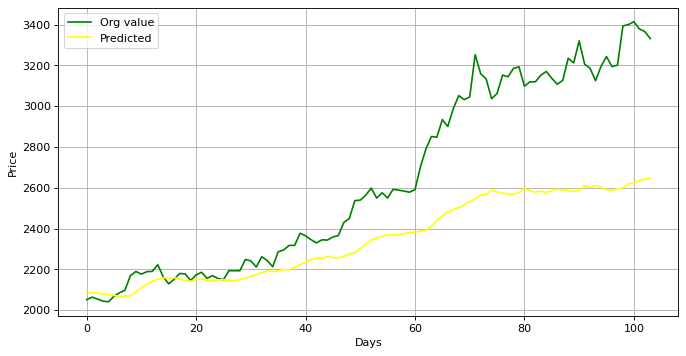

In [23]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="Green",label="Org value")
    plt.plot(output,color="Yellow",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

plotting(org_vals,output)

In [24]:
#Build a for loop with some iterations
for steps in [7,30,90]:
    for epoch in [20,30,50]:
        #prepare train data
        train_pattern = createPatternSet(data_target_scaled,steps=steps)
        #prepare test data
        test = data[len(data) - len(data_test) - steps:]
        test = scaler.transform(test)

        test_pattern = createPatternSet(test,steps=steps)
        x_test = test_pattern[0]
        y_test = test_pattern[1]
        #Build Model
        RNN1 = StocksPriceRNN(x_train,y_train,epoch)
        RNN1.buildArchitecture(2,0)
        RNN1.compiler()
        #fit model
        history = RNN1.modelfit()
        #Predict Values
        pred = RNN1.model.predict(x=x_test)
        output = scaler.inverse_transform(pred)

        #visualise
        print("Plotting for Steps {} and Epoch {}".format(steps,epoch))
        plotting(org_vals,output)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 50)               

ValueError: ignored

In [25]:
#Long Short Term Memory
class LstmModel(StocksPriceRNN):
    StocksPriceRNN.model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        super().__init__(x_train,y_train,epoch)

    def buildArchitecture(self,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.LSTM(StocksPriceRNN.neurons,input_shape=(None,1)))
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

Changed!
Changed!
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                  

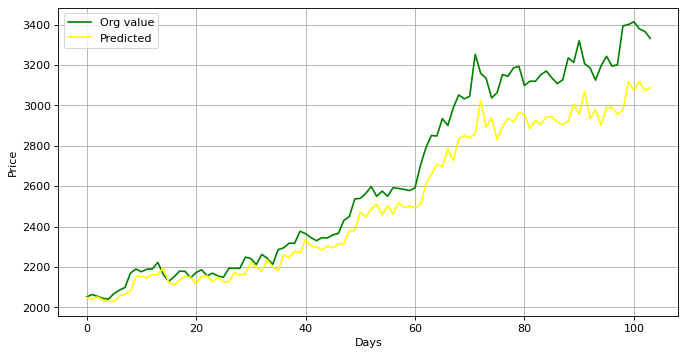

In [26]:
LSTM = LstmModel(x_train,y_train,epoch=50)
LSTM.changeBatchSize(1)
LSTM.changeNeurons(10)
LSTM.buildArchitecture()
LSTM.compiler()
history = LSTM.modelfit()

pred = LSTM.model.predict(x_test)
output = scaler.inverse_transform(pred)

plotting(org_vals,output)

Changed!
Changed!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                  

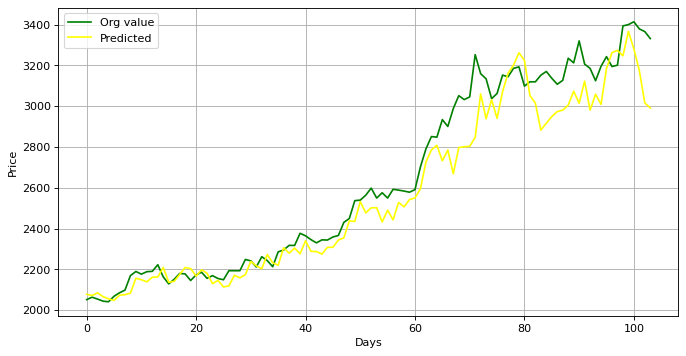

In [27]:
# Lstm with batch 2 and units 10 works best with epoch 200. Model was able to capture the actual path with minimum deviations in it.
import warnings
warnings.filterwarnings('ignore')

#Final Model Output
#prepare train data
train_pattern = createPatternSet(data_target_scaled,steps=90)
test = data[len(data) - len(data_test) - 90:]
test = scaler.transform(test)
test_pattern = createPatternSet(test,steps=90)
x_test = test_pattern[0]
y_test = test_pattern[1]
LSTM2 = LstmModel(x_train,y_train,epoch=200)
LSTM2.changeBatchSize(2)
LSTM2.changeNeurons(10)

LSTM2.buildArchitecture()
LSTM2.compiler()
history = LSTM2.modelfit()
pred = LSTM2.model.predict(x_test)
pred = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))
print("For epch {}, neurons {} and batch {}".format(200,10,2))
plotting(org_vals,pred)

In [28]:
# Future Predictions
curr_data = yf.download('ESCORTS.NS',start="2021-02-1",end="2021-06-22",interval='1d')
print("Length of Data: ",len(curr_data))
curr_data = curr_data["Adj Close"]

def futurePrediciton1D(curr_data,start="2021-02-1",end="2021-06-19"):
    '''
    '''
    curr_scaled = scaledata(curr_data)[0]
    scaler = scaledata(curr_data)[1]

    #flatten into list
    x_data = list(curr_scaled.flatten())
    #convert into 3D
    x_data = np.array(x_data)
    x_data = x_data.reshape(1,len(x_data),1)

    #Predict
    nextDay = LSTM2.model.predict(x=x_data)
    nextDay = scaler.inverse_transform(nextDay.reshape(-1,1))

    nextDay = nextDay[-1][0]
    print("Prediction: {}".format(nextDay))

    #convert into dataframe again
    curr_data = pd.DataFrame(curr_data)
    curr_data.reset_index(inplace=True)
    adj_cl = curr_data[['Adj Close']]

    #concatenate new value
    adj_cl.loc[len(adj_cl.index)] = [nextDay]

    return adj_cl

[*********************100%%**********************]  1 of 1 completed
Length of Data:  95


(95,)
(95,)
1/1 [==============================] - 0s 273ms/step
Prediction: 1155.5223388671875


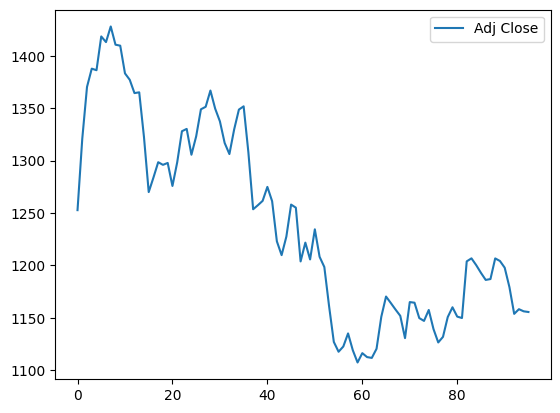

In [29]:
data = futurePrediciton1D(curr_data)
plot = data.plot()